In [2]:
import pandas as pd
import os

import sys
sys.path.append(os.path.join('..','src'))

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

from feature_engineering import HotelBookingFeatures
from data_preprocessing import DataPreprocessor
from utils import DataLoader, TrainTestSplitter

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

from model import Classification_Model

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_folder = os.path.join('..','data')
file_to_open = os.path.join(data_folder,"hotel_bookings.csv")
# load the data using the DataLoader class
data_loader = DataLoader()
hotel_bookings = data_loader.load_data(file_to_open)

In [4]:
preprocess  = DataPreprocessor()
hotel_bookings = preprocess.fit_transform(hotel_bookings)
hotel_booking_features = HotelBookingFeatures()
hotel_bookings = hotel_booking_features.fit_transform(hotel_bookings)

Converting date columns to datetime...


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 58.08it/s]


Date columns converted to datetime.

Dropping rows with missing values...


100%|██████████| 1/1 [00:00<00:00, 14.01it/s]


5 rows dropped from 150000.

Dropping duplicate rows...


100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


33 rows dropped from 149995.

Dropping rows with negative adr...


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


67 rows dropped from 149962.

Encoding categorical variables...


100%|██████████| 10/10 [00:00<00:00, 44.85it/s]


Categorical variables encoded.

hotel_name encoding:
Original values: {6.0: 'Algarve Retreat', 8.0: 'Braga City Hotel', 9.0: 'Duro Valley Resort', 11.0: 'Lisbon City Hotel', 12.0: 'Porto City Hotel'}
Encoded values: {0: 6.0, 1: 8.0, 2: 9.0, 3: 11.0, 4: 12.0, 5: 14.0, 6: 16.0, 7: 18.0, 8: 20.0, 9: 22.0, 10: 28.0, 11: 29.0, 12: 31.0, 13: 32.0, 14: 34.0, 15: 35.0, 16: 37.0, 17: 38.0, 18: 39.0, 19: 40.0, 20: 42.0, 21: 43.0, 22: 45.0, 23: 46.0, 24: 47.0, 25: 48.0, 26: 49.0, 27: 51.0, 28: 52.0, 29: 53.0, 30: 54.0, 31: 59.0, 32: 62.0, 33: 64.0, 34: 65.0, 35: 67.0, 36: 68.0, 37: 71.0, 38: 72.0, 39: 73.0, 40: 76.0, 41: 77.0, 42: 78.0, 43: 80.0, 44: 81.0, 45: 82.0, 46: 83.0, 47: 84.0, 48: 85.0, 49: 86.0, 50: 88.0, 51: 91.0, 52: 92.0, 53: 93.0, 54: 94.0, 55: 96.0, 56: 99.0, 57: 100.0, 58: 101.0, 59: 102.0, 60: 103.0, 61: 105.0, 62: 106.0, 63: 107.0, 64: 108.0, 65: 109.0, 66: 110.0, 67: 112.0, 68: 113.0, 69: 115.0, 70: 116.0, 71: 118.0, 72: 120.0, 73: 122.0, 74: 127.0, 75: 130.0, 76: 135.0, 77: 13

In [5]:
train_test_splitter = TrainTestSplitter()
X_train_resort, X_test_resort, y_train_resort, y_test_resort = train_test_splitter.split(hotel_bookings,codes=[0,2])
X_train_hotel, X_test_hotel, y_train_hotel, y_test_hotel = train_test_splitter.split(hotel_bookings,codes=[1,3,4])

X_train_resort_scaled = preprocess.scale_numerical_features(X_train_resort)
X_test_resort_scaled = preprocess.scale_numerical_features(X_test_resort)

X_train_hotel_scaled = preprocess.scale_numerical_features(X_train_hotel)
X_test_hotel_scaled = preprocess.scale_numerical_features(X_test_hotel)

columns_to_keep = ['hotel_name', 'guest_type',
       'customer_type', 'company', 'adr', 'adults', 'children',
       'babies', 'meal', 'market_segment','distribution_channel',
       'assigned_room_type','is_weekend_stay', 'num_days_stayed',
       'booking_lead_time', 'arrival_dayofweek', 'arrival_month',
       'arrival_weekofyear']

#hotel_codes = ['Braga City Hotel','Lisbon City Hotel', 'Porto City Hotel']
hotel_codes = [1, 3, 4]
#resort_names = ['Algarve Retreat' ,'Duro Valley Resort']
resort_codes = [0, 2]

X_hotel = hotel_bookings[hotel_bookings['hotel_name'].isin(hotel_codes)][columns_to_keep]
y_hotel = hotel_bookings[hotel_bookings['hotel_name'].isin(hotel_codes)]['is_canceled']

X_resort = hotel_bookings[hotel_bookings['hotel_name'].isin(resort_codes)][columns_to_keep]
y_resort = hotel_bookings[hotel_bookings['hotel_name'].isin(resort_codes)]['is_canceled']

X_hotel_scaled = preprocess.scale_numerical_features(X_hotel)
X_resort_scaled = preprocess.scale_numerical_features(X_resort)

# split the data into train and test
X_train_hotel, X_test_hotel, y_train_hotel, y_test_hotel = train_test_split(X_hotel_scaled, y_hotel, test_size=0.2, random_state=42)
X_train_resort, X_test_resort, y_train_resort, y_test_resort = train_test_split(X_resort_scaled, y_resort, test_size=0.2, random_state=42)



In [8]:
y_hotel[y_hotel==1].shape[0]/y_hotel.shape[0] * 100

NameError: name 'y_hotel' is not defined

In [8]:
y_resort[y_resort==1].shape[0]/y_resort.shape[0] * 100

28.847149743058598

# XGBoost

In [11]:
# define xgboost classifier
xgb_clf = XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state=42)

# define parameter grid
param_grid = {
    'max_depth': [9, 10],
    'n_estimators': [300, 400],
    'learning_rate': [0.1, 0.2, 0.3],
    'gamma': [0, 0.1],
    'min_child_weight': [0, 0.5],
    'lambda': [0, 1],
}

# define scoring metric as precision
scoring = 'accuracy'

In [12]:
# create grid search instance
grid_search_hotels = GridSearchCV(xgb_clf, param_grid, scoring=scoring, cv=5, n_jobs=-1)
grid_search_resorts = GridSearchCV(xgb_clf, param_grid, scoring=scoring, cv=5, n_jobs=-1)

# fit grid search on training data
grid_search_hotels.fit(X_hotel_scaled, y_hotel)
grid_search_resorts.fit(X_resort_scaled, y_resort)

# get best score and best parameters
best_score_hotels = grid_search_hotels.best_score_
best_params_hotels = grid_search_hotels.best_params_
print(f'Best score: {best_score_hotels}')
print(f'Best parameters: {best_params_hotels}')

best_score_resorts = grid_search_resorts.best_score_
best_params_resorts = grid_search_resorts.best_params_
print(f'Best score: {best_score_resorts}')
print(f'Best parameters: {best_params_resorts}')



/Users/AnasSuffo/Library/Caches/pypoetry/virtualenvs/tui-cruises-challenge-AZyxbE26-py3.11/lib/python3.11/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/AnasSuffo/Library/Caches/pypoetry/virtualenvs/tui-cruises-challenge-AZyxbE26-py3.11/lib/python3.11/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/AnasSuffo/Library/Caches/pypoetry/virtualenvs/tui-cruises-challenge-AZyxbE26-py3.11/lib/python3.11/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/AnasSuffo/Library/Caches/pypoetry/virtualenvs/

Best score: 0.6556793985314952
Best parameters: {'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 0, 'n_estimators': 300}
Best score: 0.6554808277498226
Best parameters: {'gamma': 0, 'lambda': 0, 'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 0, 'n_estimators': 400}


In [8]:
best_params_hotels = {'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 0, 'n_estimators': 300}
best_params_resorts = {'gamma': 0, 'lambda': 0, 'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 0, 'n_estimators': 400}
best_xgb_clf_hotels = XGBClassifier(**best_params_hotels,random_state=42, n_jobs=-1)
best_xgb_clf_resorts = XGBClassifier(**best_params_resorts,random_state=42, n_jobs=-1)


best_xgb_clf_hotels.fit(X_train_hotel, y_train_hotel, eval_set=[(X_train_hotel, y_train_hotel), (X_test_hotel, y_test_hotel)],
                    eval_metric='logloss', early_stopping_rounds=10)
best_xgb_clf_resorts.fit(X_train_resort, y_train_resort, eval_set=[(X_train_resort, y_train_resort), (X_test_resort, y_test_resort)],
                    eval_metric='logloss', early_stopping_rounds=10)

[0]	validation_0-logloss:0.66647	validation_1-logloss:0.66815
[1]	validation_0-logloss:0.64434	validation_1-logloss:0.64781
[2]	validation_0-logloss:0.62558	validation_1-logloss:0.63088
[3]	validation_0-logloss:0.60979	validation_1-logloss:0.61675
[4]	validation_0-logloss:0.59610	validation_1-logloss:0.60470
[5]	validation_0-logloss:0.58448	validation_1-logloss:0.59466
[6]	validation_0-logloss:0.57393	validation_1-logloss:0.58578
[7]	validation_0-logloss:0.56503	validation_1-logloss:0.57840
[8]	validation_0-logloss:0.55686	validation_1-logloss:0.57202
[9]	validation_0-logloss:0.54980	validation_1-logloss:0.56667
[10]	validation_0-logloss:0.54351	validation_1-logloss:0.56188
[11]	validation_0-logloss:0.53793	validation_1-logloss:0.55775
[12]	validation_0-logloss:0.53268	validation_1-logloss:0.55378
[13]	validation_0-logloss:0.52809	validation_1-logloss:0.55037
[14]	validation_0-logloss:0.52391	validation_1-logloss:0.54735
[15]	validation_0-logloss:0.51980	validation_1-logloss:0.54467
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0, learning_rate=0.3,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=-1, num_parallel_tree=None,
              predictor=None, ...)

In [7]:
numeric_columns = ['adr','adults', 'children', 'babies','num_days_stayed', 
                                'booking_lead_time', 'arrival_dayofweek', 'arrival_month',
                                'arrival_weekofyear']
# create a model instance and train the classifiers
hotel_model = Classification_Model(X_train_hotel, y_train_hotel, X_test_hotel, y_test_hotel, cols_to_scale=numeric_columns)
hotel_model.train_decision_tree()
hotel_model.train_random_forest()
hotel_model.train_xgboost()
hotel_model.train_logistic_regression()

# evaluate the classifiers
#hotel_model.evaluate()
hotel_model.plot_feature_importance()
hotel_model.confusion_matrix()

Training decision tree classifier...


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Decision tree classifier trained.

Training random forest classifier...


100%|██████████| 1/1 [00:07<00:00,  7.71s/it]


Random forest classifier trained.

Training XGBoost classifier...


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


XGBoost classifier trained.

Training logistic regression classifier...


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Logistic regression classifier trained.

Plotting feature importance...


  0%|          | 0/3 [00:00<?, ?it/s]


AttributeError: 'DataFrame' object has no attribute 'append'

In [6]:
resort_model = Model(X_train_resort, y_train_resort, X_test_resort, y_test_resort, cols_to_scale=numeric_columns)
resort_model.train_decision_tree()
resort_model.train_random_forest()
resort_model.train_xgboost()
resort_model.train_logistic_regression()

# evaluate the classifiers
resort_model.evaluate()
resort_model.plot_feature_importance()
resort_model.confusion_matrix()

Training decision tree classifier...


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Decision tree classifier trained.

Training random forest classifier...


100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


Random forest classifier trained.

Training XGBoost classifier...


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


XGBoost classifier trained.

Training logistic regression classifier...


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Logistic regression classifier trained.

Evaluating classifiers...


100%|██████████| 4/4 [00:00<00:00, 12.96it/s]

| Classifier          |   Accuracy |   Precision |   Recall |   F1 Score | Classification Report                                 |
|---------------------+------------+-------------+----------+------------+-------------------------------------------------------|
| Decision Tree       |   0.667795 |    0.671354 | 0.667795 |   0.669506 | precision    recall  f1-score   support               |
|                     |            |             |          |            |                                                       |
|                     |            |             |          |            |            0       0.77      0.76      0.76      7145 |
|                     |            |             |          |            |            1       0.43      0.44      0.43      2897 |
|                     |            |             |          |            |                                                       |
|                     |            |             |          |            |     accu

In [9]:
# print classification report
y_pred_hotels = best_xgb_clf_hotels.predict(X_test_hotel)
print('Classification report for hotels: \n', classification_report(y_test_hotel, y_pred_hotels))

y_pred_resorts = best_xgb_clf_resorts.predict(X_test_resort)
print('Classification report for resorts: \n', classification_report(y_test_resort, y_pred_resorts))


Classification report for hotels: 
               precision    recall  f1-score   support

           0       0.73      0.95      0.82     12646
           1       0.81      0.38      0.52      7292

    accuracy                           0.74     19938
   macro avg       0.77      0.66      0.67     19938
weighted avg       0.76      0.74      0.71     19938

Classification report for resorts: 
               precision    recall  f1-score   support

           0       0.75      0.95      0.84      7145
           1       0.64      0.23      0.33      2897

    accuracy                           0.74     10042
   macro avg       0.69      0.59      0.59     10042
weighted avg       0.72      0.74      0.69     10042



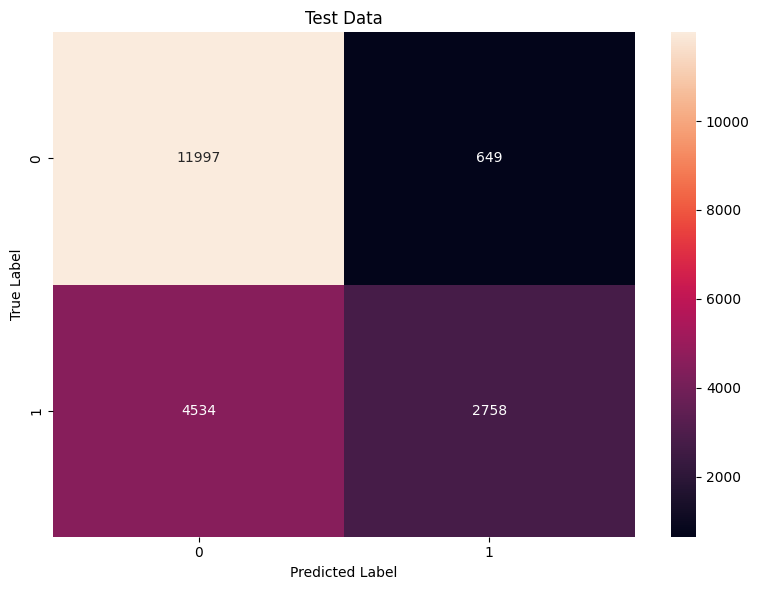

In [10]:
# plot the confusion matrix for both train and test data
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_hotel,y_pred_hotels), annot=True, fmt='d', ax=ax)
ax.set_title('Test Data')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.tight_layout()
plt.show()

In [46]:
import numpy as np
# define models to test:
tree_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
                ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
                ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]
                                      
logistic_model = ("LR_model", LogisticRegression(random_state=42, n_jobs=-1))

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 5 # 4 = 80% train, 20% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

# do a grid search for each model:
for name, model in base_models:
    # define hyperparameters to search for each model:
    if name == "DT_model":
        param_grid = {"max_depth": [None, 5, 10],
                      "min_samples_leaf": [1, 5, 10],
                      "max_features": ["auto", "sqrt", "log2"]}
    elif name == "RF_model":
        param_grid = {"n_estimators": [100, 200, 300],
                      "max_depth": [None, 5, 10],
                      "min_samples_leaf": [1, 5],
                      "max_features": ["auto", "sqrt"]}
    elif name == "LR_model":
        param_grid = {"C": [0.1, 1, 10, 100],
                      "solver": ["liblinear"]}
    elif name == "XGB_model":
        param_grid = {"n_estimators": [100, 200, 300],
                      "max_depth": [None, 5, 10],
                      "learning_rate": [0.1, 0.01, 0.001]}
    
    # do the grid search:
    grid_search = GridSearchCV(model, 
                               param_grid=param_grid,
                               cv=split,
                               scoring="accuracy",
                               n_jobs=-1,
                               verbose=1)
    grid_search.fit(X, y)
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best score for {name}: {grid_search.best_score_}")
    print(f"Best estimator for {name}: {grid_search.best_estimator_}")
    print("")
# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    
    # get cross validation score for each model:
    cv_results = cross_val_score(model, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 3)
    max_score = round(max(cv_results), 3)
    mean_score = round(np.mean(cv_results), 3)
    std_dev = round(np.std(cv_results), 3)
    print(f"{name} cross validation accuracy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")
    


Fitting 5 folds for each of 27 candidates, totalling 135 fits


Best parameters for DT_model: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10}
Best score for DT_model: 0.7082224223623202
Best estimator for DT_model: DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=10,
                       random_state=42)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


KeyboardInterrupt: 